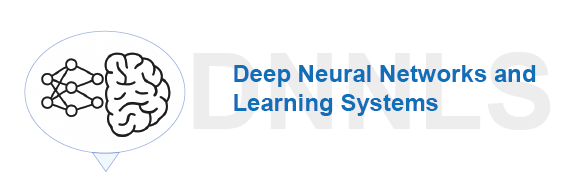

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [ ]:
!pip uninstall -y sympy torchvision torch
!pip install sympy==1.11.1
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118


In [ ]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


In [ ]:
from datasets import load_dataset

dataset = load_dataset("daniel3303/StoryReasoning")
train_data = dataset["train"]
test_data  = dataset["test"]

from torch.utils.data import random_split
train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
print(dataset)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8  # safe for Colab

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [ ]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [ ]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [ ]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

In [ ]:
# ===== Load StoryReasoning Dataset =====
dataset = load_dataset("daniel3303/StoryReasoning")

train_data_full = dataset["train"]
test_data = dataset["test"]

# Create validation split
train_size = int(0.8 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])

print(len(train_data), len(val_data), len(test_data))


In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [ ]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)

        # Potential experiments: Try using the other attributes in your training
        # objects = self.image_attributes[frame_idx]["objects"]
        # actions = self.image_attributes[frame_idx]["actions"]
        # locations = self.image_attributes[frame_idx]["locations"]

        description = self.image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

        description_list.append(input_ids.squeeze(0))


      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

      sequence_tensor = torch.stack(frame_tensors)  # shape: (num_frames, C, H, W)
      description_tensor = torch.stack(description_list) # (num_frames, max_length)

      return (sequence_tensor, # Returning the image
              description_tensor, # Returning the whole description
              image_target, # Image target
              target_ids) # Text target



We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [ ]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description  # Returning the whole description


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [ ]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



In [ ]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer) # Instantiate the train dataset
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer) # Instantiate the test dataset

# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


In [ ]:
# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [ ]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

In [ ]:
# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

In [ ]:
latent_dim = 16
emb_dim = 128
num_layers = 1
dropout = 0.1

# IMPORTANT: GRU hidden dimension (GLOBAL)
gru_hidden_dim = latent_dim


## 2.1 The NLP models

In [ ]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        gru_hidden_dim = latent_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [ ]:
# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [ ]:
# @title Do some tests
# desc = text_dataset[np.random.randint(0, 100)]
# print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

## 2.2 The Vision models

In [ ]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



In [ ]:
# ==================================================
# Tokenizer setup
# Purpose:
#   Prepare text inputs for the language components
#   of the model before defining the main architecture
# ==================================================

from transformers import AutoTokenizer

# Load a standard BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Ensure padding token exists (safety check)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Tokenizer ready. Vocabulary size:", tokenizer.vocab_size)


In [ ]:
print(tokenizer.pad_token_id)


## 2.3 The main architecture


In [ ]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [ ]:
# ==================================================
# Temporal Attention (Improvement)
# Purpose:
#   Learn which frames matter more across time (T)
#   and produce one strong sequence representation.
# ==================================================

class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Step 1: Project each frame feature to an attention space
        self.attention_proj = nn.Linear(hidden_dim, hidden_dim)

        # Step 2: Convert projected features into a single score per frame
        self.attention_score = nn.Linear(hidden_dim, 1)

        # Step 3: Normalise scores over the time dimension (T)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, frame_embeddings):
        """
        Args:
            frame_embeddings: Tensor (B, T, D)
                B = batch size
                T = number of frames
                D = feature dimension

        Returns:
            attended_representation: Tensor (B, D)
            attention_weights: Tensor (B, T)
        """

        # Create attention features
        attn_features = torch.tanh(self.attention_proj(frame_embeddings))  # (B, T, D)

        # Convert to attention scores
        attn_scores = self.attention_score(attn_features).squeeze(-1)      # (B, T)

        # Normalise to weights
        attn_weights = self.softmax(attn_scores)                           # (B, T)

        # Weighted sum of frames -> one vector (B, D)
        attended_representation = torch.sum(
            frame_embeddings * attn_weights.unsqueeze(-1),
            dim=1
        )

        return attended_representation, attn_weights


In [ ]:
print("TemporalAttention loaded:", TemporalAttention)


In [ ]:
class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder,
                 latent_dim, gru_hidden_dim):
        super().__init__()

        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        fusion_dim = latent_dim * 2
        self.temporal_rnn = nn.GRU(
            fusion_dim, gru_hidden_dim, batch_first=True
        )

        self.attention = Attention(gru_hidden_dim)
        self.temporal_attention = TemporalAttention(gru_hidden_dim)

        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 16)
        self.fused_to_c0 = nn.Linear(latent_dim, 16)

        self.use_temporal_attention = False

    def forward(self, image_seq, text_seq, target_seq):

        batch_size, seq_len, C, H, W = image_seq.shape

        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        txt_flat = text_seq.view(batch_size * seq_len, -1)

        z_visual = self.image_encoder(img_flat)
        _, hidden, cell = self.text_encoder(txt_flat)

        z_fused = torch.cat((z_visual, hidden.squeeze(0)), dim=1)
        z_fused_seq = z_fused.view(batch_size, seq_len, -1)

        zseq, h = self.temporal_rnn(z_fused_seq)
        h = h.squeeze(0)

        baseline_context = self.attention(zseq)
        temporal_context, _ = self.temporal_attention(zseq)

        context = temporal_context if self.use_temporal_attention else baseline_context

        z = self.projection(torch.cat((h, context), dim=1))

        pred_image_content, pred_image_context = self.image_decoder(z)

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :, :-1].squeeze(1)
        predicted_text_logits_k, _, _ = self.text_decoder(
            decoder_input, h0, c0
        )

        return (
            pred_image_content,
            pred_image_context,
            predicted_text_logits_k,
            h0,
            c0
        )


In [ ]:
# visual_autoencoder.apply(init_weights)


In [ ]:
visual_autoencoder = VisualAutoencoder(latent_dim=16)

# visual_autoencoder.apply(init_weights)

total_params = sum(
    p.numel() for p in visual_autoencoder.parameters() if p.requires_grad
)
print(f"Total trainable parameters in visual autoencoder: {total_params}")


In [ ]:
print(visual_autoencoder)


In [ ]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention_proj = nn.Linear(hidden_dim, hidden_dim)
        self.attention_score = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, frame_embeddings):
        attn_features = torch.tanh(self.attention_proj(frame_embeddings))
        attn_scores = self.attention_score(attn_features).squeeze(-1)
        attn_weights = self.softmax(attn_scores)
        attended = torch.sum(
            frame_embeddings * attn_weights.unsqueeze(-1),
            dim=1
        )
        return attended, attn_weights


In [ ]:
# @title Initializing the NLP models

encoder = EncoderLSTM(
    tokenizer.vocab_size,
    emb_dim,
    latent_dim,
    num_layers,
    dropout
).to(device)

decoder = DecoderLSTM(
    tokenizer.vocab_size,
    emb_dim,
    latent_dim,
    num_layers,
    dropout
).to(device)

text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)

# No pretrained checkpoint available, using random initialisation
total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")

# Freeze text autoencoder parameters (baseline behaviour)
for param in text_autoencoder.parameters():
    param.requires_grad = False


In [ ]:
sequence_predictor = SequencePredictor(
    visual_autoencoder,
    text_autoencoder,
    latent_dim,
    gru_hidden_dim
).to(device)

sequence_predictor.use_temporal_attention = False


In [ ]:
print(sequence_predictor)


# **Chapter 3: Training routines**


---




### Training Setup Note

The model was trained for a limited number of epochs (4–5 epochs).
This was done due to computational and time constraints in the Colab environment.

The goal of training was to demonstrate learning behaviour and compare
the baseline and modified architectures qualitatively, rather than
to achieve fully converged or optimal results.


In [ ]:
val_losses = []


In [ ]:
# @title Training utility functions: To initialize and to visualize the progress


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)


# Plots four images and their reconstructions
def validation( model, data_loader ):
  model.eval()
  with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(data_loader))

    descriptions = descriptions.to(device)
    frames = frames.to(device)
    image_target = image_target.to(device)
    text_target = text_target.to(device)

    predicted_image_k,context_image, _, hidden, cell = model(frames, descriptions, text_target)

    figure, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    for i in range(4):
      im = frames[0, i, :, :, :].cpu()
      show_image(ax[0,i], im )
      ax[0,i].set_aspect('auto')
      ax[0,i].axis('off')
      wrapped_text = textwrap.fill(tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True), width=40)

      ax[1,i].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=True
        )

      ax[1,i].axis('off') # Hide axes for the text subplot

    show_image(ax[0,4], image_target[0].cpu())
    ax[0,4].set_title('Target')
    ax[0,4].set_aspect('auto')
    ax[0,4].axis('off')
    text_target = text_target.squeeze(1)

    wrapped_text = textwrap.fill(tokenizer.decode(text_target[0], skip_special_tokens=True), width=40)
    ax[1,4].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False)
    ax[1,4].axis('off')
    output = context_image[0, :, :, :].cpu()
    show_image(ax[0,5], output)
    ax[0,5].set_title('Predicted')
    ax[0,5].set_aspect('auto')
    ax[0,5].axis('off')

    generated_tokens = generate(model.text_decoder,
                                hidden[:,0, :].unsqueeze(1),
                                cell[:, 0, :].unsqueeze(1),
                                max_len=150,
                                sos_token_id=tokenizer.cls_token_id,
                                eos_token_id=tokenizer.sep_token_id)

    wrapped_text = textwrap.fill(tokenizer.decode(generated_tokens), width=40)

    ax[1,5].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False )
    ax[1,5].axis('off')
    plt.tight_layout()
    plt.show()


## 3.1 Initialization and setup

In [ ]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 5
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [ ]:
encoder = EncoderLSTM(
    tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout
).to(device)

decoder = DecoderLSTM(
    tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout
).to(device)

text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)

# Pretrained checkpoint not available → using random init (baseline safe)
total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")

for param in text_autoencoder.parameters():
    param.requires_grad = False


In [ ]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

In [ ]:
# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim, latent_dim)
sequence_predictor.to(device)

# # Print number of trainable parameters
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")

# Print model size
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")

## 3.2 Training loops

In [ ]:
# @title Training tools
criterion_images = nn.L1Loss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.Adam(sequence_predictor.parameters(), lr=0.001)

In [ ]:
# @title Training loop for the sequence predictor

sequence_predictor.train()
losses = []

for epoch in range(N_EPOCHS):

    running_loss = 0.0

    # -------- TRAINING --------
    for frames, descriptions, image_target, text_target in train_dataloader:

        frames = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target = text_target.to(device)

        # Forward pass
        pred_image_content, pred_image_context, predicted_text_logits_k, _, _ = \
            sequence_predictor(frames, descriptions, text_target)

        # Image reconstruction loss
        loss_im = criterion_images(pred_image_content, image_target)

        # Context loss
        mu_global = frames.mean(dim=[0, 1])
        mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
        loss_context = criterion_ctx(pred_image_context, mu_global)

        # Text prediction loss
        prediction_flat = predicted_text_logits_k.reshape(
            -1, tokenizer.vocab_size
        )
        target_labels = text_target.squeeze(1)[:, 1:]
        target_flat = target_labels.reshape(-1)
        loss_text = criterion_text(prediction_flat, target_flat)

        # Total loss
        loss = loss_im + loss_text + 0.2 * loss_context

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)

    # Average training loss
    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_train_loss)

    # -------- VALIDATION --------
    sequence_predictor.eval()
    print("Validation on validation dataset")
    print("-------------------------------")
    validation(sequence_predictor, val_dataloader)
    sequence_predictor.train()

    # Logging (FIXED: no val_loss formatting)
    print(
        f"Epoch [{epoch+1}/{N_EPOCHS}] "
        f"Train Loss: {epoch_train_loss:.4f}"
    )

    # Save checkpoint
    if epoch % 5 == 0:
        save_checkpoint_to_drive(
            sequence_predictor,
            optimizer,
            epoch,
            epoch_train_loss,
            filename="sequence_predictor.pth"
        )

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.savefig("training_loss.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

In [ ]:
sequence_predictor.eval()

with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(val_dataloader))
    frames = frames.to(device)
    descriptions = descriptions.to(device)
    text_target = text_target.to(device)

    _, _, predicted_text_logits_k, _, _ = sequence_predictor(
        frames, descriptions, text_target
    )

# Convert prediction to tokens
pred_ids = torch.argmax(predicted_text_logits_k, dim=-1)

generated_text = tokenizer.batch_decode(
    pred_ids, skip_special_tokens=True
)

print("Generated story example:\n")
print(generated_text[0])


# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!

In [ ]:
# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Tensors to accumulate sum (for mean) and sum of squares (for variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)] # Placeholder for variance numerator
transform = transforms.Compose([transforms.ToTensor()])

# --- First Pass: Calculate the Sum (for Mean) ---
print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])
        avg_images[j] += image # Sum for mean

# Final step for mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])

        # Calculate (Image - Mean)^2
        # Note: We detach the mean from the computation graph if it were being trained,
        # but here we're just using it as a fixed statistical value.
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff # Element-wise squaring

# --- Final step for Standard Deviation ---
std_images = []
for j in range(5):
    # Variance = Sum of Squared Differences / N
    variance = sum_sq_diff[j] / N

    # Standard Deviation = sqrt(Variance)
    std_dev = torch.sqrt(variance)
    std_images.append(std_dev)

print("Computation Complete. std_images is a list of 5 tensors (3x60x125).")
# You now have the 5 tensors you need for normalization (mean and std).

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
  avg_image = avg_images[i]

  # Printing range of avg_image
  print(torch.min(avg_image), torch.max(avg_image))

  avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
  show_image(ax[i], avg_imagen)

# Create a matrix of images with the differences between avg_images
fig, ax = plt.subplots(5,5, figsize=(15,8))

for i in range(5):
  for j in range(5):
    if i == j:
      avg_image = avg_images[i]
      avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
      show_image(ax[i,j], avg_imagen)
    else:
      diff = avg_images[i] - avg_images[j]
      diff = (diff - torch.min(diff))/(torch.max(diff) - torch.min(diff))
      show_image(ax[i,j], diff)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(
    wspace=0, # Set horizontal space to zero
    hspace=0  # Set vertical space to zero
)